
# CNN - Modelling (Multi + MOG + VGG)

# 1. Construct `ImageDataGenerator` Instance

In [1]:
import tensorflow as tf
%matplotlib inline

CLASS = "Mul"
PRE = "MOG"
TECH = "VGG"

print(tf.__version__)

2.4.2


In [2]:
! nvidia-smi

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Mon Aug 23 02:49:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.142.00   Driver Version: 450.142.00   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   27C    P8     9W /  70W |      0MiB / 15109MiB |      0%    

We center and standardize all images at per image level.

Image flips, 180 degree image rotations and image brightness is suitable for data augmentation. However, shift and zoom are not appropriate because some crackes are located at the edge of some images. Zoom and shift may remove those crackes.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True,
                                    vertical_flip=True,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True)

datagen_test = ImageDataGenerator(samplewise_center=True,
                                   samplewise_std_normalization=True)

Then, load the data from directory: to relieve the burden of memory usage, import the image as 150 $\times$ 150 squares.

In [4]:
SRC_MULTI = "/home/ubuntu/crack/MOG-Multi/"

from crack_utils import load_multi_dataset

x_train, x_test, y_train, y_test = load_multi_dataset(SRC_MULTI, (150, 150))

We can see that the classes are extremely imbalanced.

In [5]:
import numpy as np
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4]), array([1158,  716,  484,  100,   83]))

In [6]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2, 3, 4]), array([385, 238, 161,  33,  27]))

Two common ways to alleviate this issue:

* Over-sampling minority classes by image augmentation (e.g., flip)

* Set class weight in training.

However, we've found that such methods cannot lead to a better validation accuracy and F1 score.

Still, we left the code here:

```python
# Over-sampling minority classes by image augmentation
from crack_utils import augment_data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen_temp = ImageDataGenerator()
x_train, y_train = augment_data(x_train, y_train, gen_temp)

# Set class weight in training.
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))
```

Add to a data iterator:

In [7]:
from tensorflow.keras.utils import to_categorical

# convert integers to dummy variables (i.e. one hot encoded)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

train_it = datagen_train.flow(x_train, y_train, batch_size=64, seed=100)
test_it = datagen_test.flow(x_test, y_test, batch_size=64, shuffle=False)

# 2. VGG Model

## 2.1 Baseline Model 

We consider VGG blocks in our baseline model.

### 2.2.2 One Block VGG Model

In [8]:
from crack_utils import vgg_block, classification_block, multiple_compile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def one_block_VGG():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 2)
    # add classification block
    layer = classification_block(layer, 16, classes=5)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = one_block_VGG()
multiple_compile(model, 0.001, 0.9)
model.summary()

Extension horovod.torch has not been built: /home/ubuntu/anaconda3/envs/tensorflow2_latest_p37/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2021-08-23 02:49:54.419 ip-172-31-5-51:10101 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-08-23 02:49:54.487 ip-172-31-5-51:10101 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 32)      320       
________________

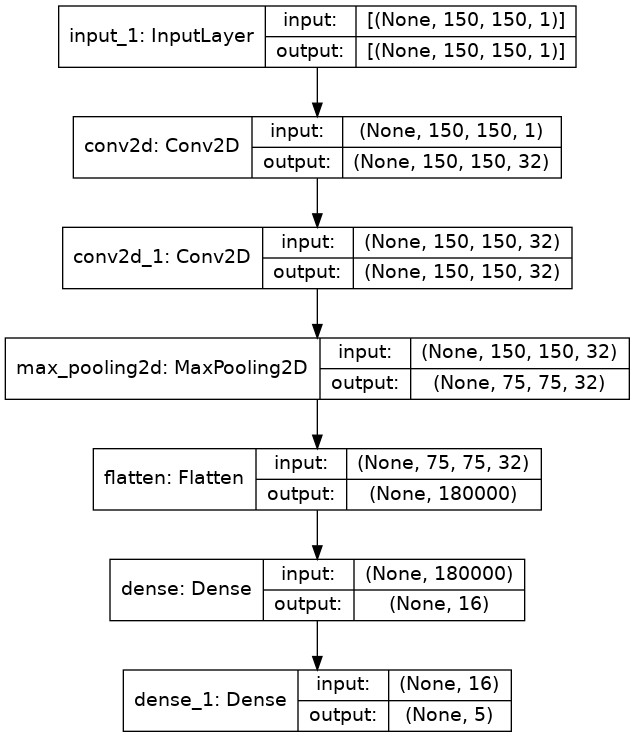

In [9]:
from tensorflow.keras.utils import plot_model

# plot model architecture
model_name = "{}_{}_{}_1".format(CLASS, PRE, TECH)
plot_model(model, show_shapes=True, to_file='model_image/{}.png'.format(model_name))

In [10]:
%%time

histories = dict()

histories[model_name] = model.fit(x=train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 19s, sys: 2.62 s, total: 1min 22s
Wall time: 1min 22s


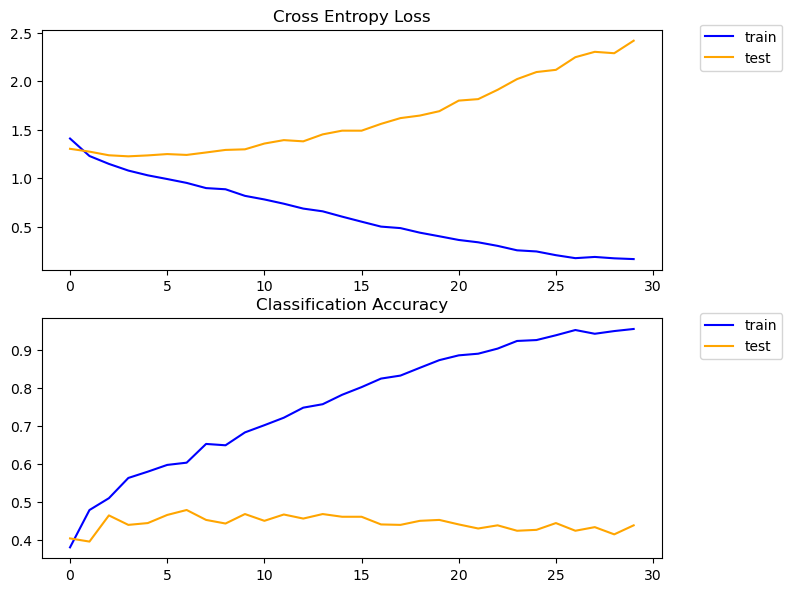

In [11]:
from crack_utils import summarize_diagnostics_multi
                                           
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [12]:
from crack_utils import show_result_multi

results = dict()

results[model_name] = show_result_multi(model, test_it, y_test)

Test loss: 2.42
Test accuracy: 0.44
Test f1 micro: 0.44
Test f1 macro: 0.27
Test f1 weighted: 0.42


### 2.1.2 Two Block VGG Model

In [13]:
def two_block_VGG():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 2)
    layer = vgg_block(layer, 64, 2)
    # add classification block
    layer = classification_block(layer, 16, classes=5)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = two_block_VGG()
multiple_compile(model, 0.001, 0.9)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0   

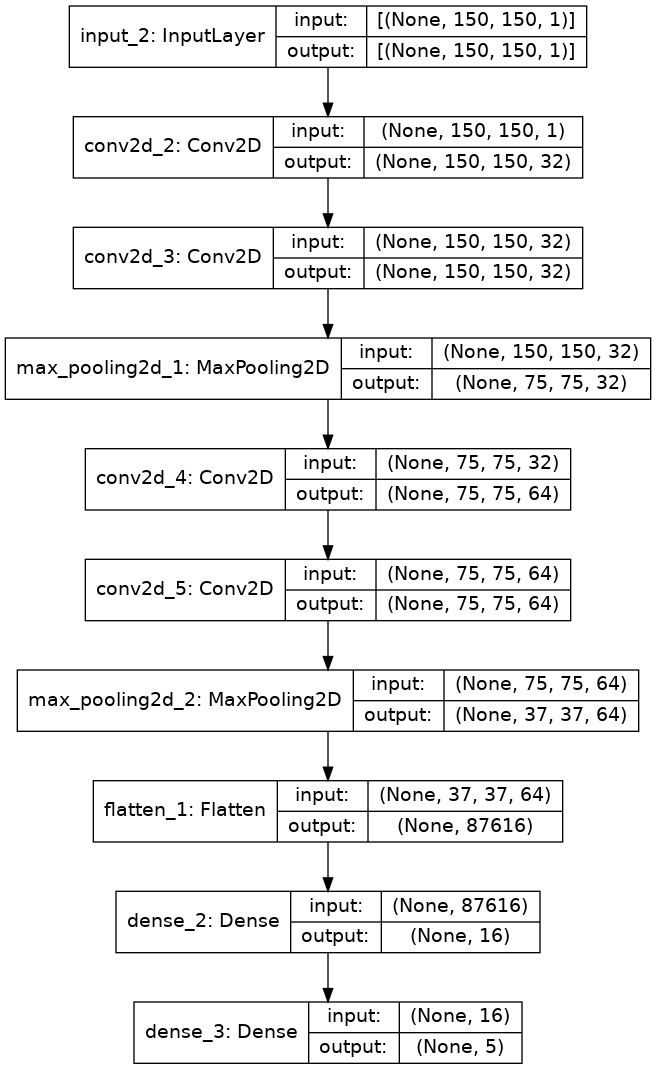

In [14]:
# plot model architecture
model_name = "{}_{}_{}_2".format(CLASS, PRE, TECH)
plot_model(model, show_shapes=True, to_file='model_image/{}.png'.format(model_name))

In [15]:
%%time

histories[model_name] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 42s, sys: 2.36 s, total: 1min 44s
Wall time: 1min 51s


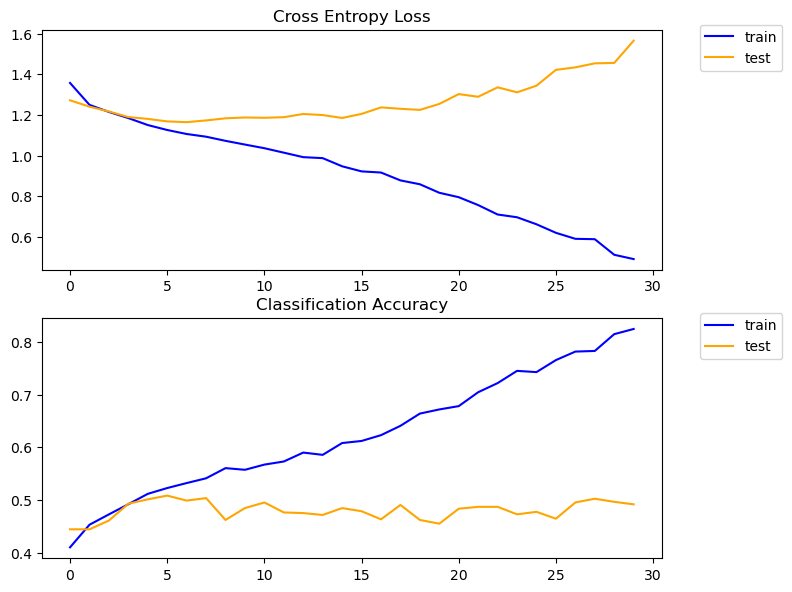

In [16]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [17]:
results[model_name] = show_result_multi(model, test_it, y_test)

Test loss: 1.56
Test accuracy: 0.49
Test f1 micro: 0.49
Test f1 macro: 0.33
Test f1 weighted: 0.47


### 2.1.3 Three Block VGG Model

In [18]:
def three_block_VGG():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 2)
    layer = vgg_block(layer, 64, 2)
    layer = vgg_block(layer, 128, 2)
    # add classification block
    layer = classification_block(layer, 16, classes=5)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = three_block_VGG()
multiple_compile(model, 0.001, 0.9)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 37, 37, 64)        0   

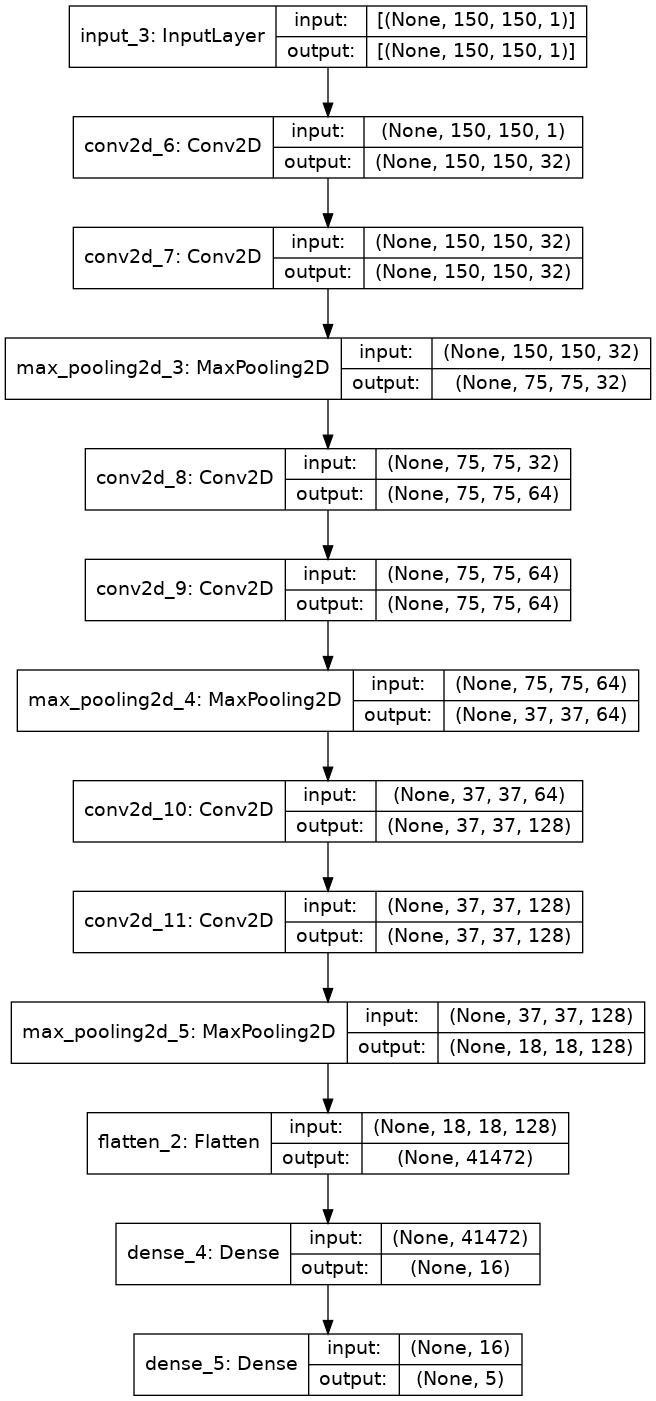

In [19]:
# plot model architecture
model_name = "{}_{}_{}_3".format(CLASS, PRE, TECH)
plot_model(model, show_shapes=True, to_file='model_image/{}.png'.format(model_name))

In [20]:
%%time

histories[model_name] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 55s, sys: 4.09 s, total: 1min 59s
Wall time: 2min 9s


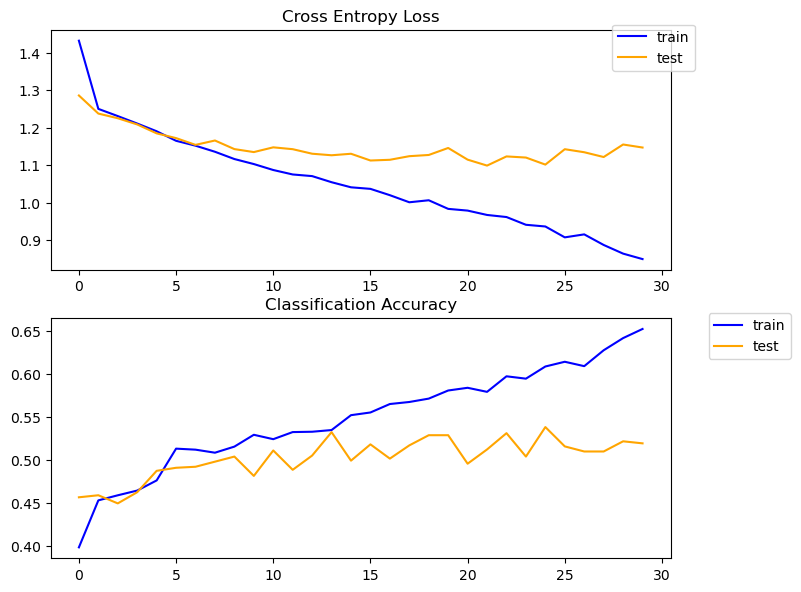

In [21]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [22]:
results[model_name] = show_result_multi(model, test_it, y_test)

Test loss: 1.15
Test accuracy: 0.52
Test f1 micro: 0.52
Test f1 macro: 0.36
Test f1 weighted: 0.50


## 2.2 Model Improvements

### 2.2.1 Dropout Regularization



In [23]:
from tensorflow.keras.layers import Dropout

def three_block_VGG_dropout():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 2)
    layer = Dropout(0.2)(layer)
    layer = vgg_block(layer, 64, 2)
    layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 2)
    layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16, classes=5)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = three_block_VGG_dropout()
multiple_compile(model, 0.001, 0.9)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 150, 150, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 64)        3692

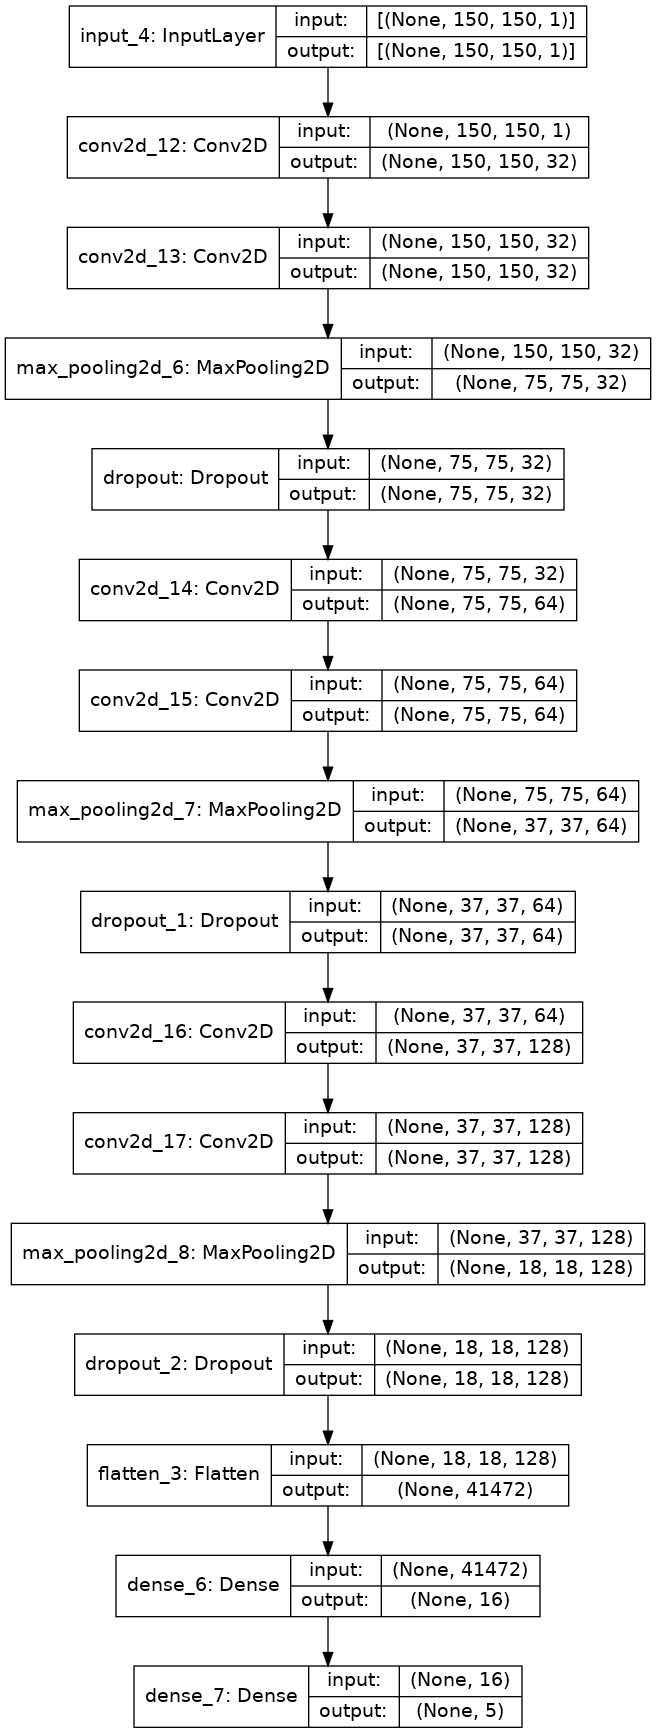

In [24]:
# plot model architecture
model_name = "{}_{}_{}_3_dropout".format(CLASS, PRE, TECH)
plot_model(model, show_shapes=True, to_file='model_image/{}.png'.format(model_name))

In [25]:
%%time

histories[model_name] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 1min 52s, sys: 3.54 s, total: 1min 56s
Wall time: 2min 15s


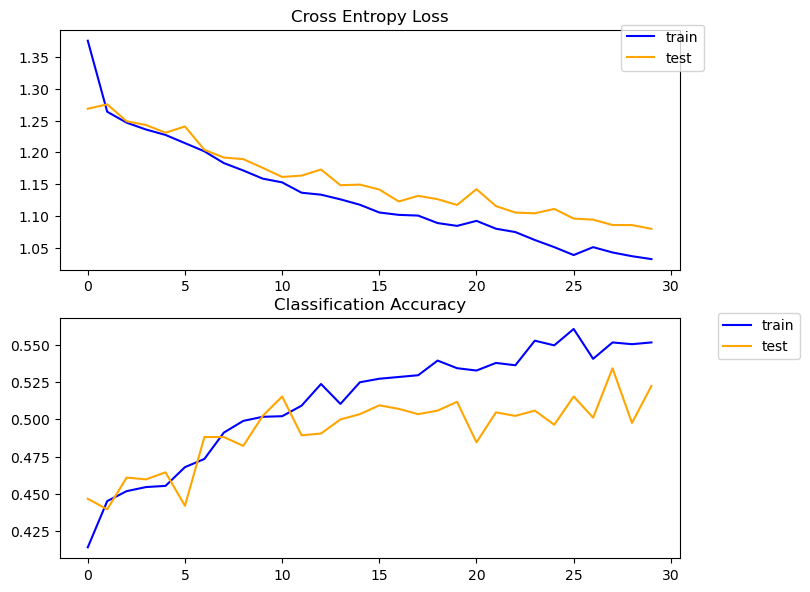

In [26]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [27]:
results[model_name] = show_result_multi(model, test_it, y_test)

Test loss: 1.08
Test accuracy: 0.52
Test f1 micro: 0.52
Test f1 macro: 0.31
Test f1 weighted: 0.49


### 2.2.1 Weight Decay + Dropout

In [28]:
from tensorflow.keras.regularizers import l2

def three_block_VGG_dropout_decay():
    # define model input
    visible = Input(shape=(150, 150, 1))
    # add vgg module
    layer = vgg_block(visible, 32, 1, decay=l2(0.01))
    layer = Dropout(0.2)(layer)
    layer = vgg_block(layer, 64, 1, decay=l2(0.01))
    layer = Dropout(0.3)(layer)
    layer = vgg_block(layer, 128, 1, decay=l2(0.01))
    layer = Dropout(0.4)(layer)
    # add classification block
    layer = classification_block(layer, 16, decay=l2(0.01), classes=5)
    # create model
    model = Model(inputs=visible, outputs=layer)
    return model

# create model instance
model = three_block_VGG_dropout_decay()
multiple_compile(model, 0.001, 0.9)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 37, 37, 64)        0   

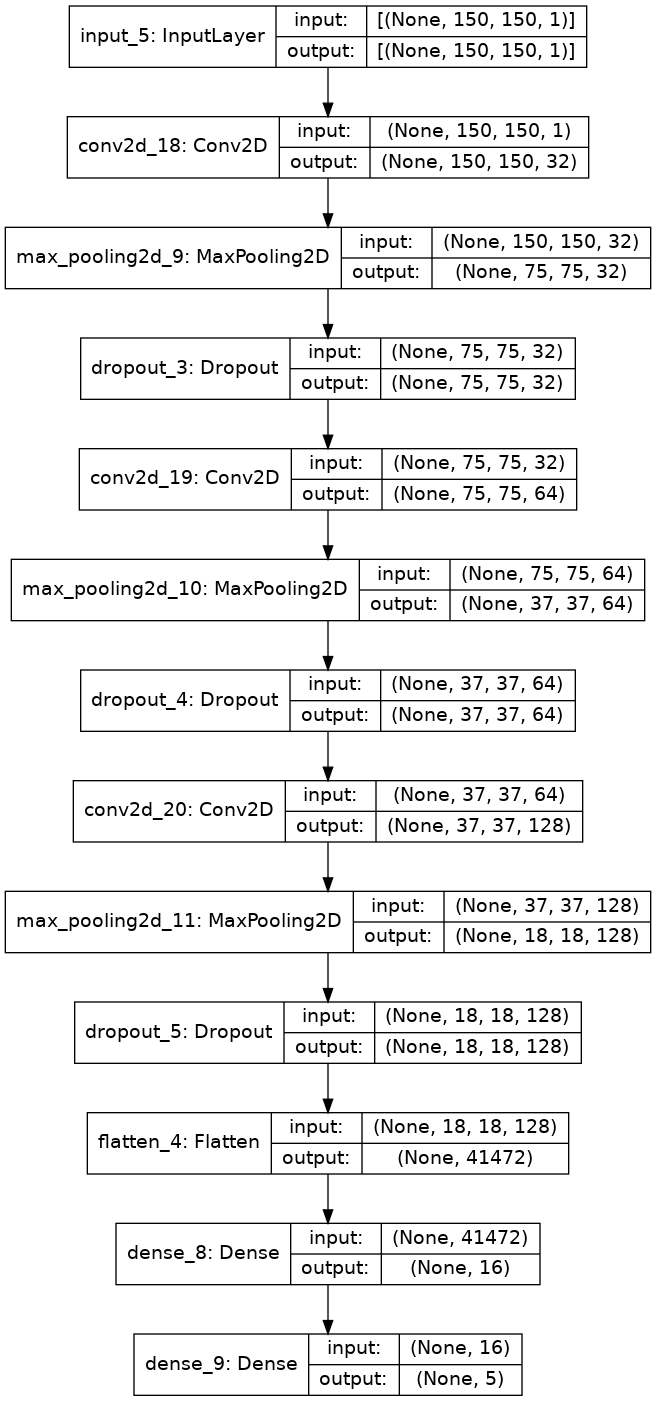

In [29]:
# plot model architecture
model_name = "{}_{}_{}_3_dropout_decay".format(CLASS, PRE, TECH)
plot_model(model, show_shapes=True, to_file='model_image/{}.png'.format(model_name))

In [30]:
%%time

histories[model_name] = model.fit(train_it, steps_per_epoch=len(train_it),
              validation_data=test_it, validation_steps=len(test_it), epochs=30, verbose=0).history

CPU times: user 58 s, sys: 2.57 s, total: 1min
Wall time: 59.4 s


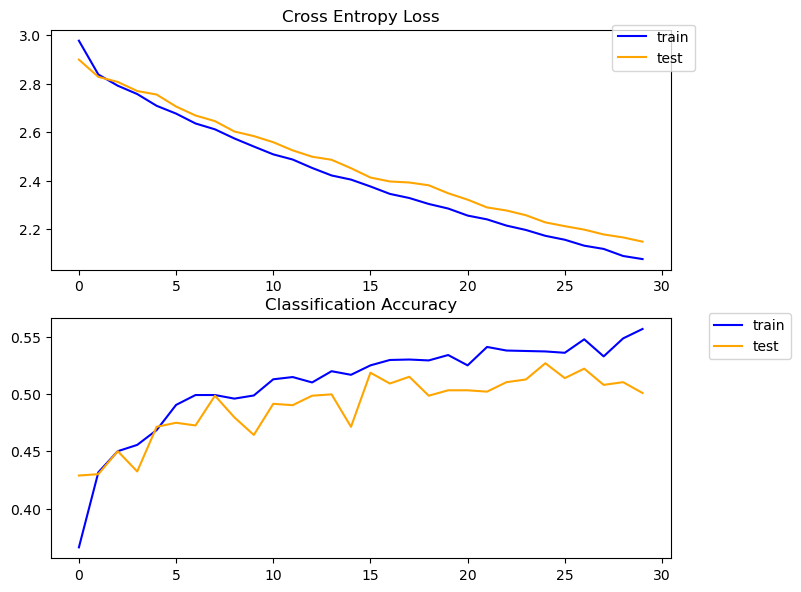

In [31]:
summarize_diagnostics_multi(histories[model_name], "model_plot/{}.png".format(model_name))

In [32]:
results[model_name] = show_result_multi(model, test_it, y_test)

Test loss: 2.15
Test accuracy: 0.50
Test f1 micro: 0.50
Test f1 macro: 0.30
Test f1 weighted: 0.47


# 3. Summary

Final result:

In [33]:
from crack_utils import get_final_result

get_final_result(results).round(2)

,Mul_MOG_VGG_1,Mul_MOG_VGG_2,Mul_MOG_VGG_3,Mul_MOG_VGG_3_dropout,Mul_MOG_VGG_3_dropout_decay
Loss,2.42,1.56,1.15,1.08,2.15
Accuracy,0.44,0.49,0.52,0.52,0.50
F1 Micro,0.44,0.49,0.52,0.52,0.50
F1 Macro,0.27,0.33,0.36,0.31,0.30
F1 Weighted,0.42,0.47,0.50,0.49,0.47


Compare each model:

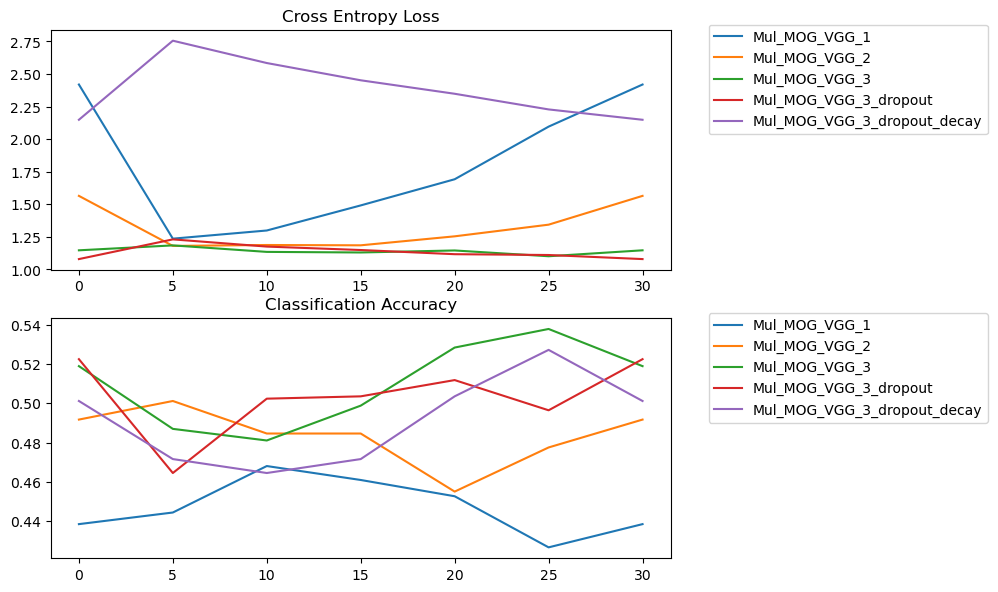

In [34]:
from crack_utils import compare_all_result_multi

compare_all_result_multi(histories, filename="model_plot/Compare_{}_{}_{}.png".format(CLASS, PRE, TECH), end=30, step=5)

Save epochs history:

In [35]:
from crack_utils import save_history

save_history(histories, folder="epochs_history")